In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


In [14]:
# full_img_path = '/mnt/d/Datasets/INbreast_new_train/full/'
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/CLAHE_2/'
img_height = 224
img_width = 224
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/INbreast_new_train_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  class_names=['benign','malignant'],
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  class_names=['benign','malignant'],
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 905 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [16]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  class_names=['benign','malignant'],
  shuffle=False,
  batch_size=batch_size)
train_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  class_names=['benign','malignant'],
  shuffle=False,
  batch_size=batch_size)
val_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  class_names=['benign','malignant'],
  shuffle=False,
  batch_size=batch_size)
# test = test_ds.prefetch(AUTOTUNE)

Found 72 files belonging to 2 classes.
Found 905 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [17]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')
Model_Training = Model_Training()

# Inception V3

In [18]:
train_log = '/home/jj/FYP/log/InceptionV3_INbreast_new_train/'
weight = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_new_train/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0     

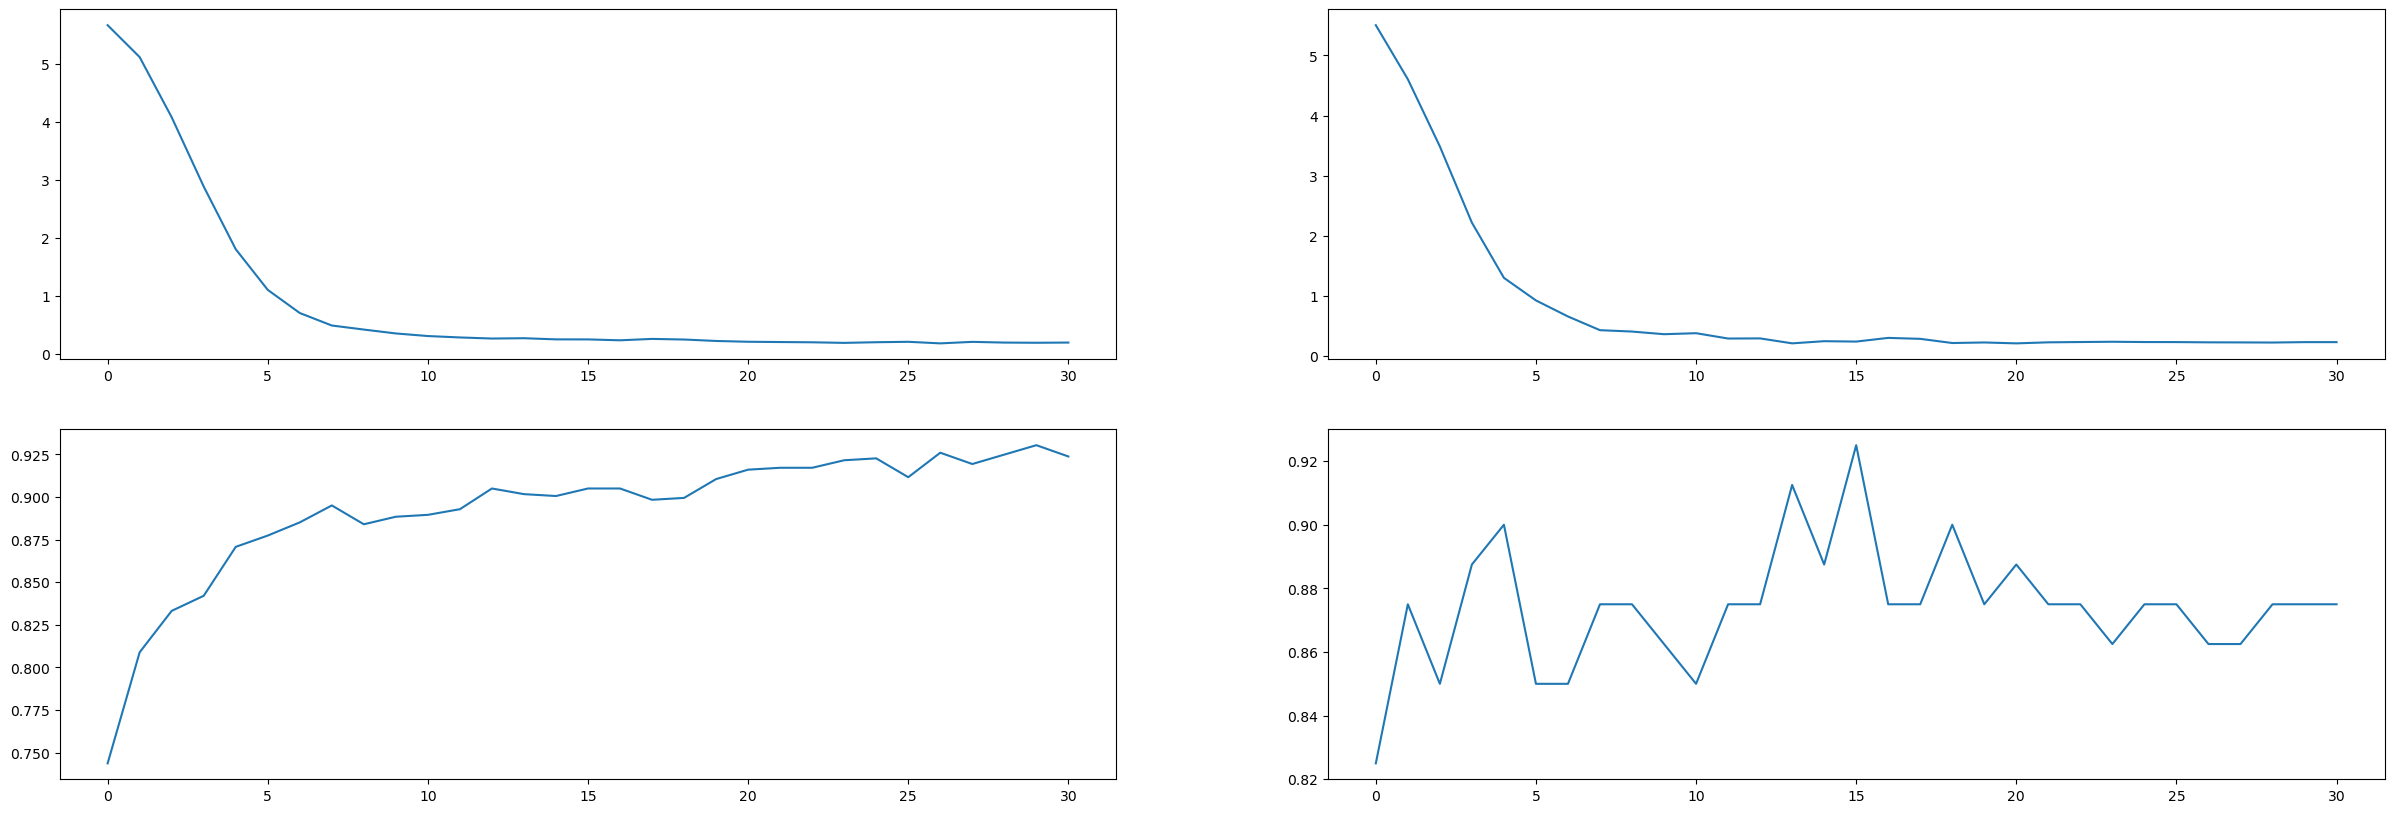

In [19]:
tf.keras.backend.clear_session()
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    flatten='flatten',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'dense.csv',
    load_weights = False,
    save_weights = weight+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-5,min_lr=1e-6,
    warmup=5,cosine=10,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0     

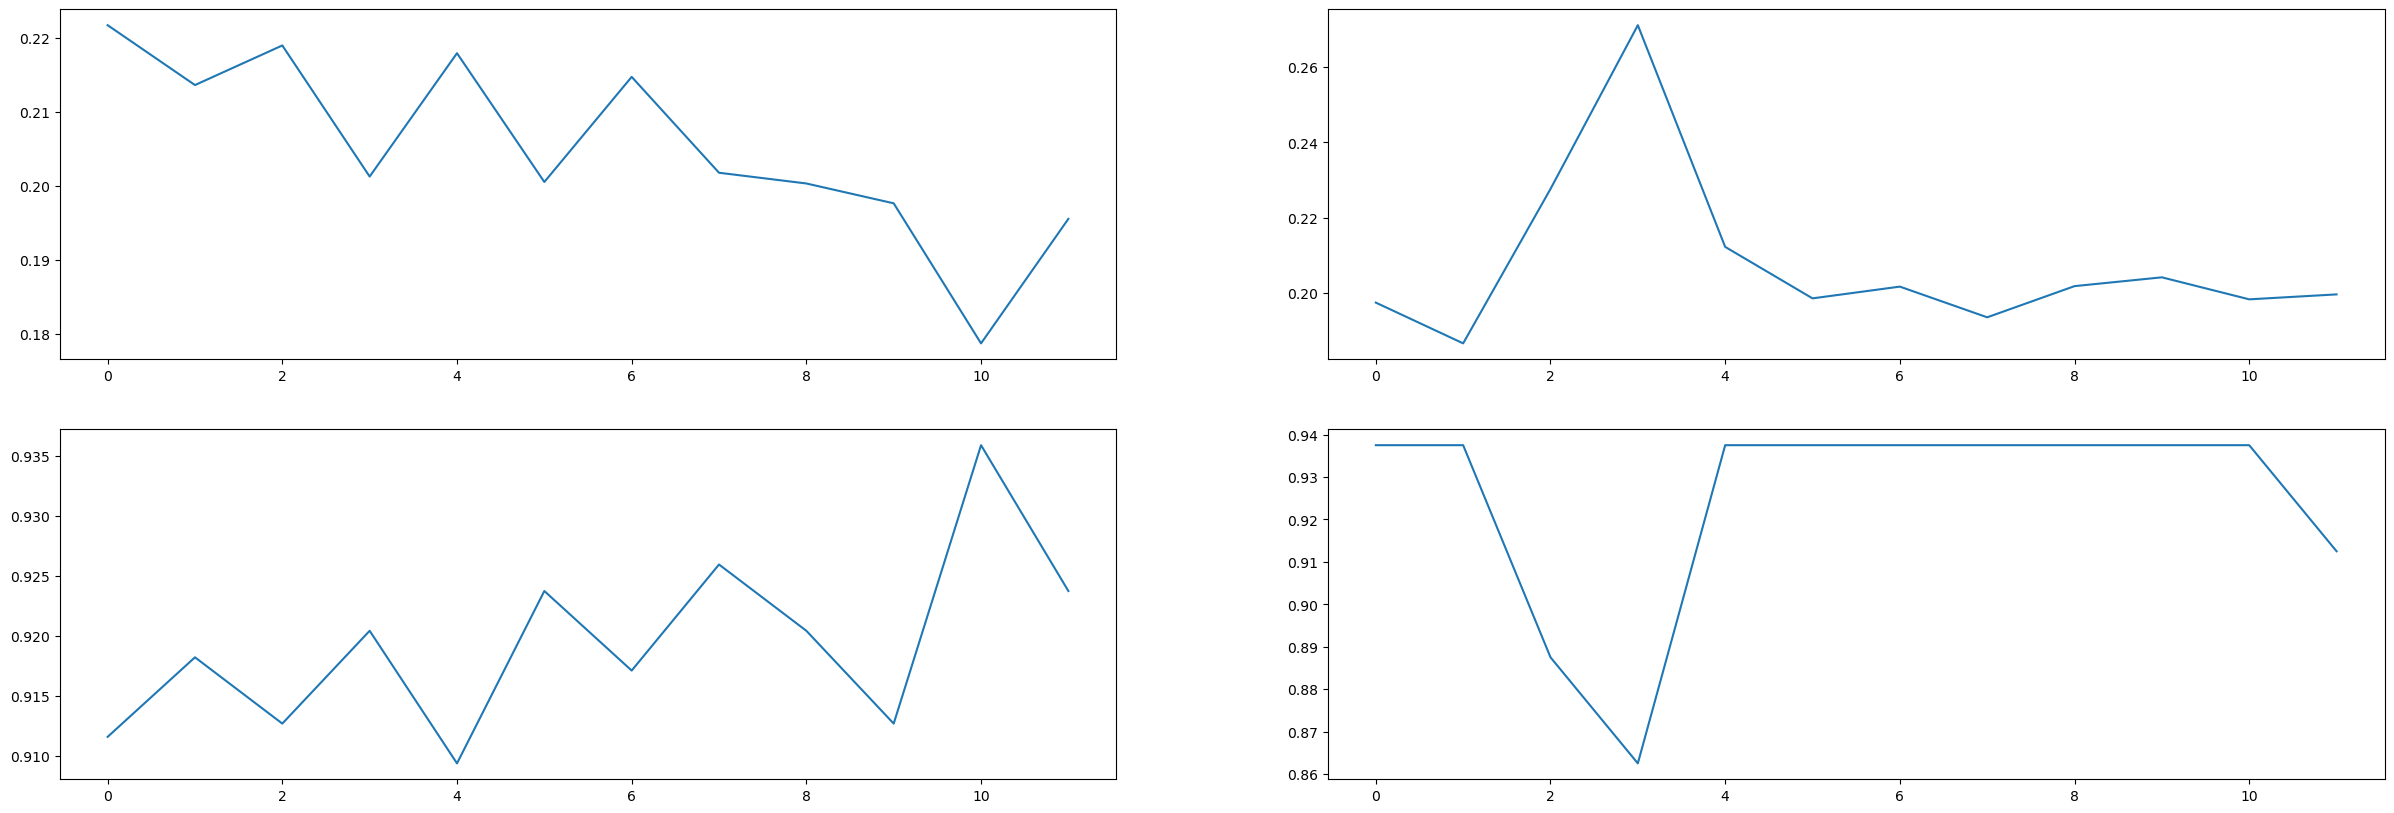

In [20]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    flatten='flatten',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune.csv',
    load_weights = weight+'Dense/best_model',
    save_weights = weight+'Fine_Tune/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=0,cosine=10, min_lr=1e-5,                                                                                                                                                                                                                                                                                                                                                                                                                                  
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

model.save_weights(weight+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               262149

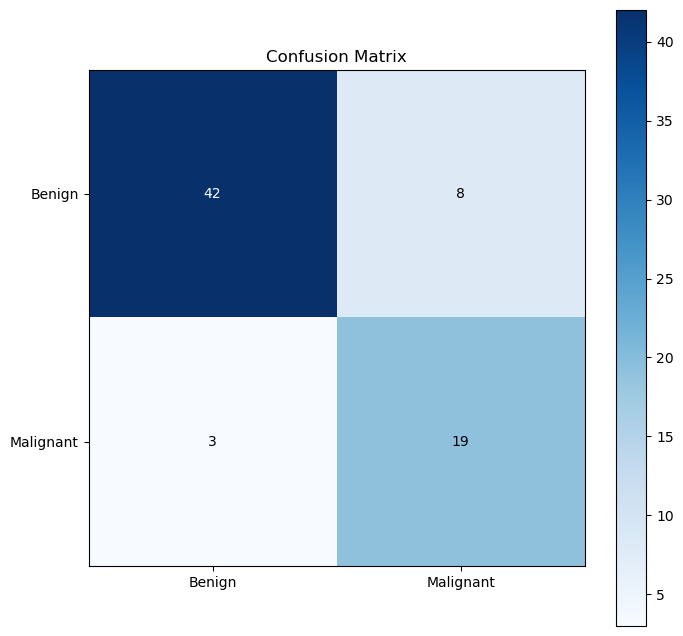

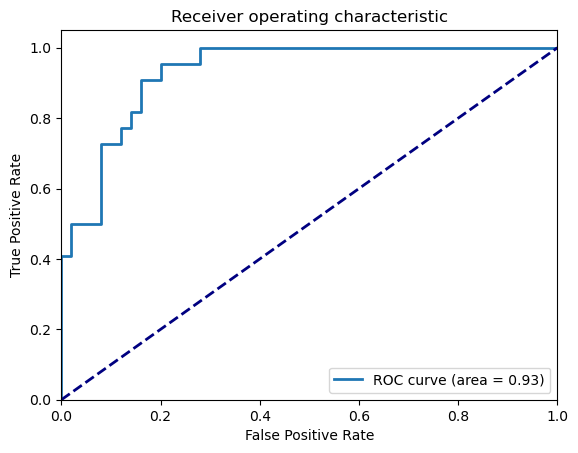

In [21]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='flatten',load_weights=weight+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

In [22]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='flatten',load_weights=weight+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               262149

In [23]:
# store_misclassified = misclassified_store+'inceptionv3/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

5/5 [==============================] - 1s 23ms/step


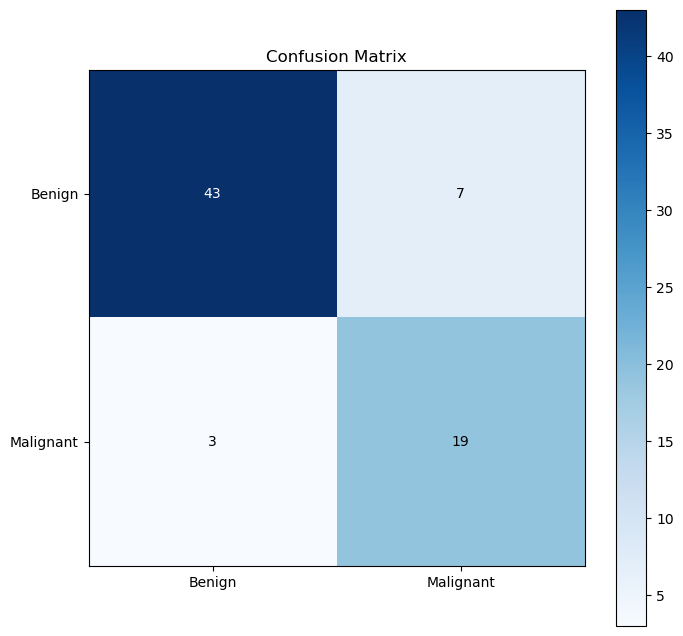

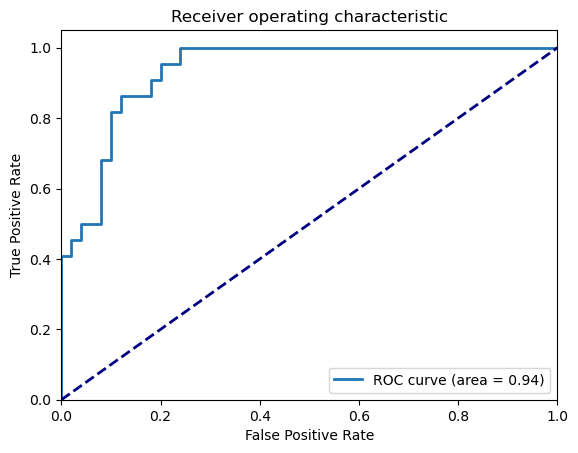

In [24]:
# model.load_weights(weight+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# Resnet50

## Initialising

In [13]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Resnet50_INbreast_new_train/'

In [14]:
tf.keras.backend.clear_session()
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,flatten='flatten',
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=5,cosine=20,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                             

KeyboardInterrupt: 

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                             

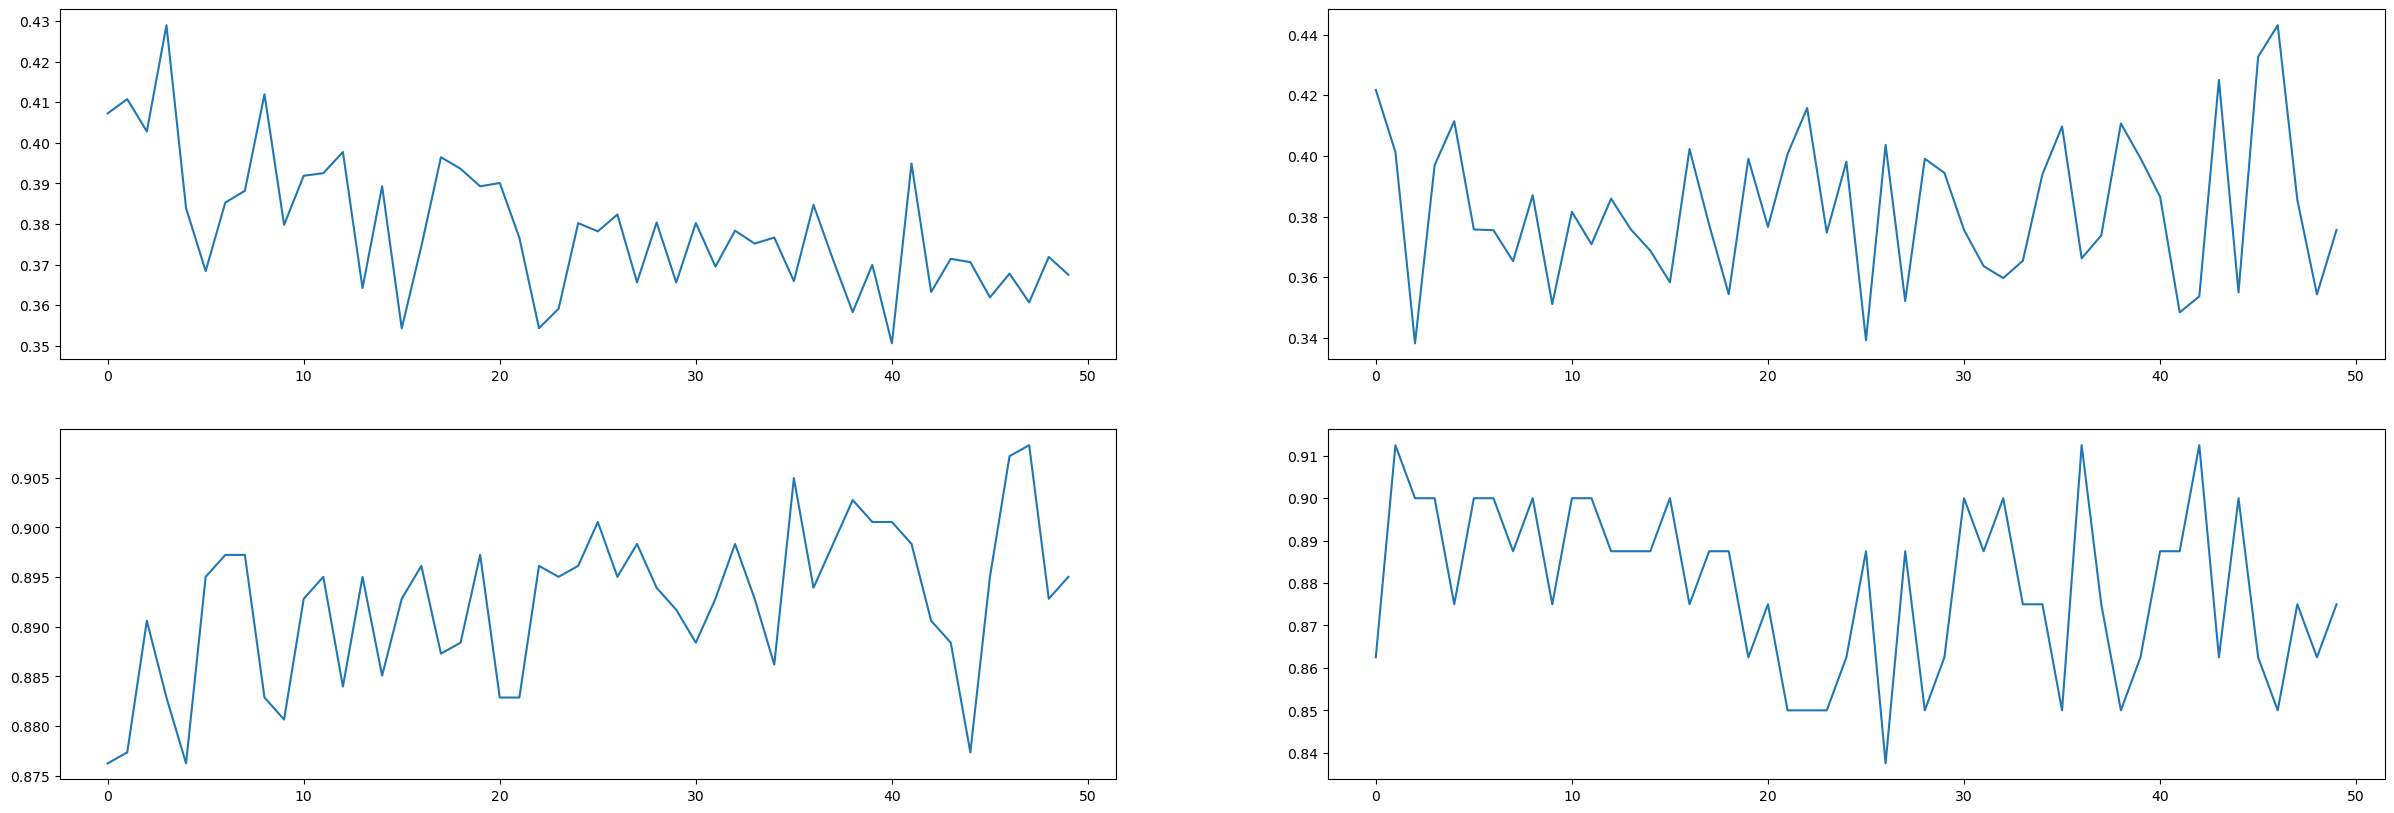

In [ ]:
tf.keras.backend.clear_session()
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = 22,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                             

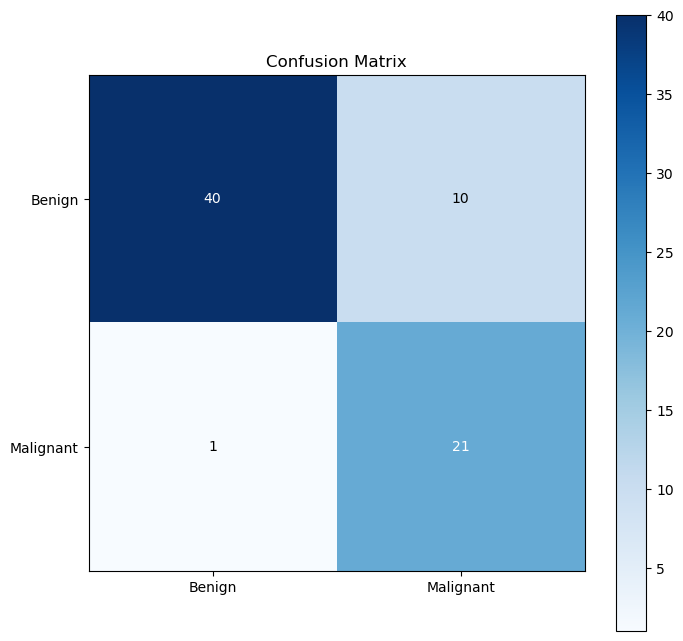

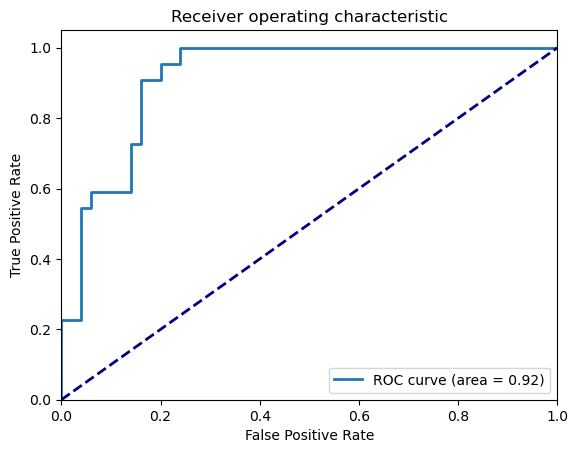

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='flatten',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                             

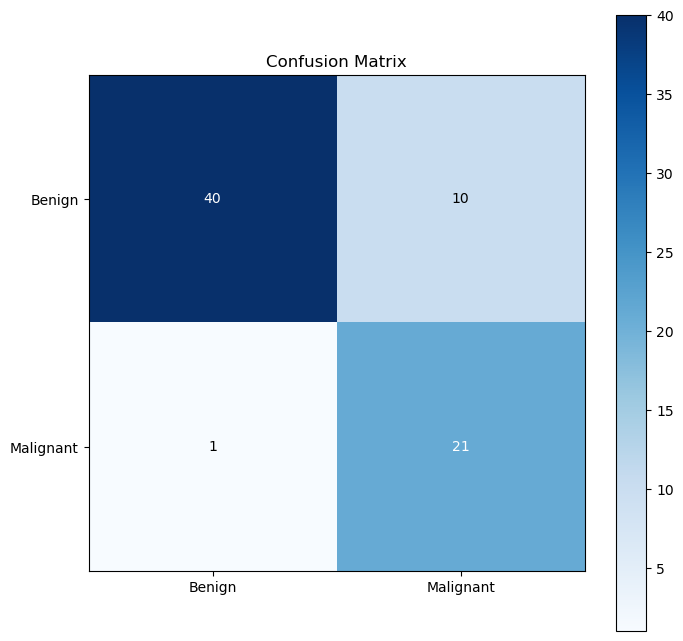

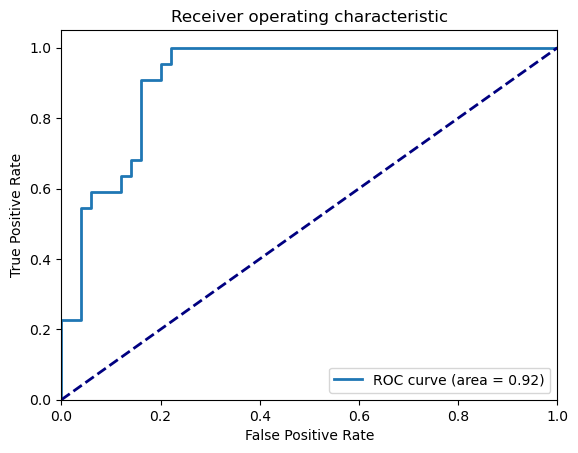

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='flatten',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)


In [ ]:
# store_misclassified = misclassified_store+'resnet50/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

# VGG16

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Vgg16_INbreast_new_train/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

2023-03-15 20:34:32.836638: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 20:34:32.840001: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


57/57 [==============================] - 20s 236ms/step - loss: 3.7975 - categorical_accuracy: 0.4685 - precision: 0.4807 - precision_1: 0.4582 - val_loss: 2.8416 - val_categorical_accuracy: 0.5250 - val_precision: 0.5278 - val_precision_1: 0.5227
Epoch 2/2
57/57 [==============================] - 11s 186ms/step - loss: 2.2253 - categorical_accuracy: 0.5834 - precision: 0.6467 - precision_1: 0.5521 - val_loss: 2.0616 - val_categorical_accuracy: 0.5875 - val_precision: 0.7692 - val_precision_1: 0.5522
Epoch 3/3
57/57 [==============================] - 11s 182ms/step - loss: 1.9829 - categorical_accuracy: 0.6674 - precision: 0.7867 - precision_1: 0.6123 - val_loss: 1.7804 - val_categorical_accuracy: 0.7375 - val_precision: 1.0000 - val_precision_1: 0.6557
Epoch 4/4
57/57 [==============================] - 11s 182ms/step - loss: 1.6425 - categorical_accuracy: 0.7470 - precision: 0.8391 - precision_1: 0.6894 - val_loss: 1.4628 - val_categorical_accuracy: 0.7500 - val_precision: 0.9545 - va

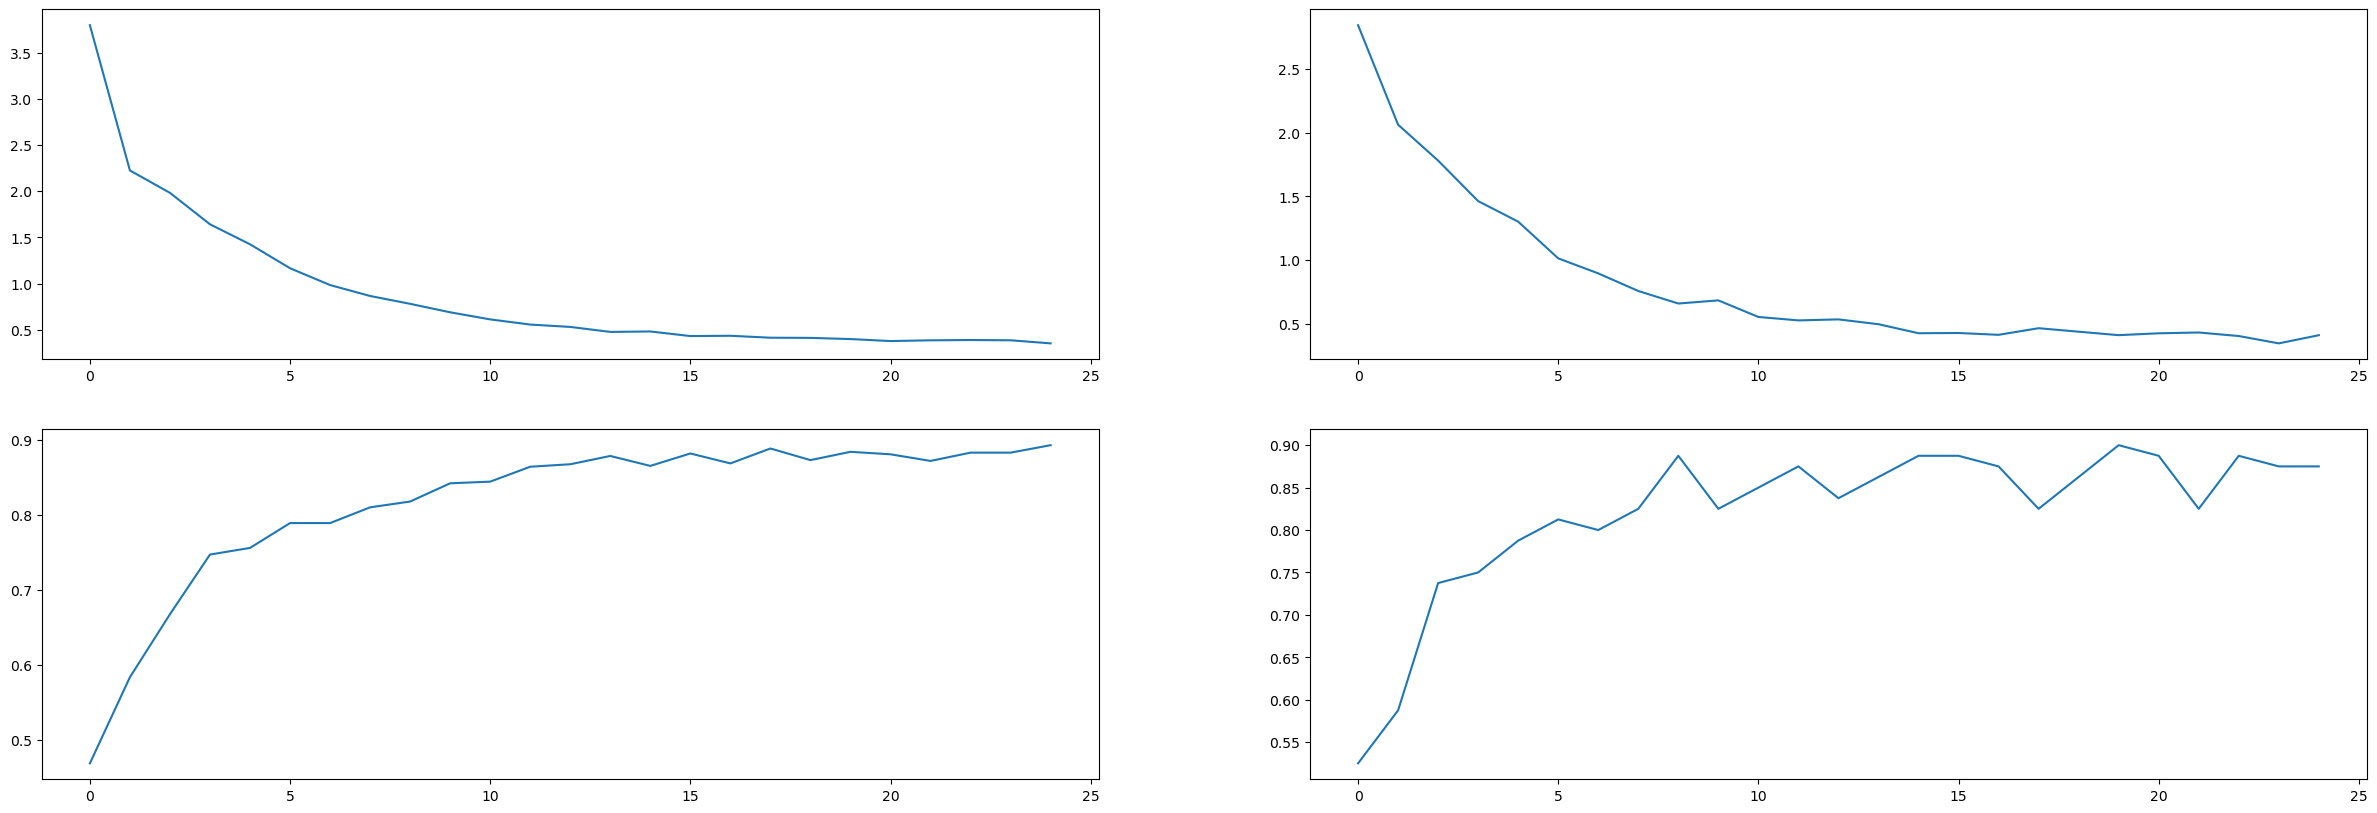

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Vgg16_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Vgg16_INbreast_new_train/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = False,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=5,cosine=20,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

2023-03-15 20:39:16.920122: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 20:39:16.920173: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 20:39:16.959689: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 20:39:16.959737: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

57/57 [==============================] - 20s 280ms/step - loss: 0.3758 - categorical_accuracy: 0.8829 - precision: 0.9204 - precision_1: 0.8494 - val_loss: 0.4115 - val_categorical_accuracy: 0.8625 - val_precision: 0.8718 - val_precision_1: 0.8537
Epoch 2/2
57/57 [==============================] - 14s 240ms/step - loss: 0.3601 - categorical_accuracy: 0.8895 - precision: 0.9234 - precision_1: 0.8586 - val_loss: 0.4322 - val_categorical_accuracy: 0.8750 - val_precision: 1.0000 - val_precision_1: 0.8000
Epoch 3/3
57/57 [==============================] - 14s 240ms/step - loss: 0.3951 - categorical_accuracy: 0.8751 - precision: 0.9171 - precision_1: 0.8385 - val_loss: 0.3524 - val_categorical_accuracy: 0.8875 - val_precision: 1.0000 - val_precision_1: 0.8163
Epoch 4/4
57/57 [==============================] - 14s 239ms/step - loss: 0.3502 - categorical_accuracy: 0.8994 - precision: 0.9269 - precision_1: 0.8737 - val_loss: 0.3803 - val_categorical_accuracy: 0.8750 - val_precision: 0.9688 - va

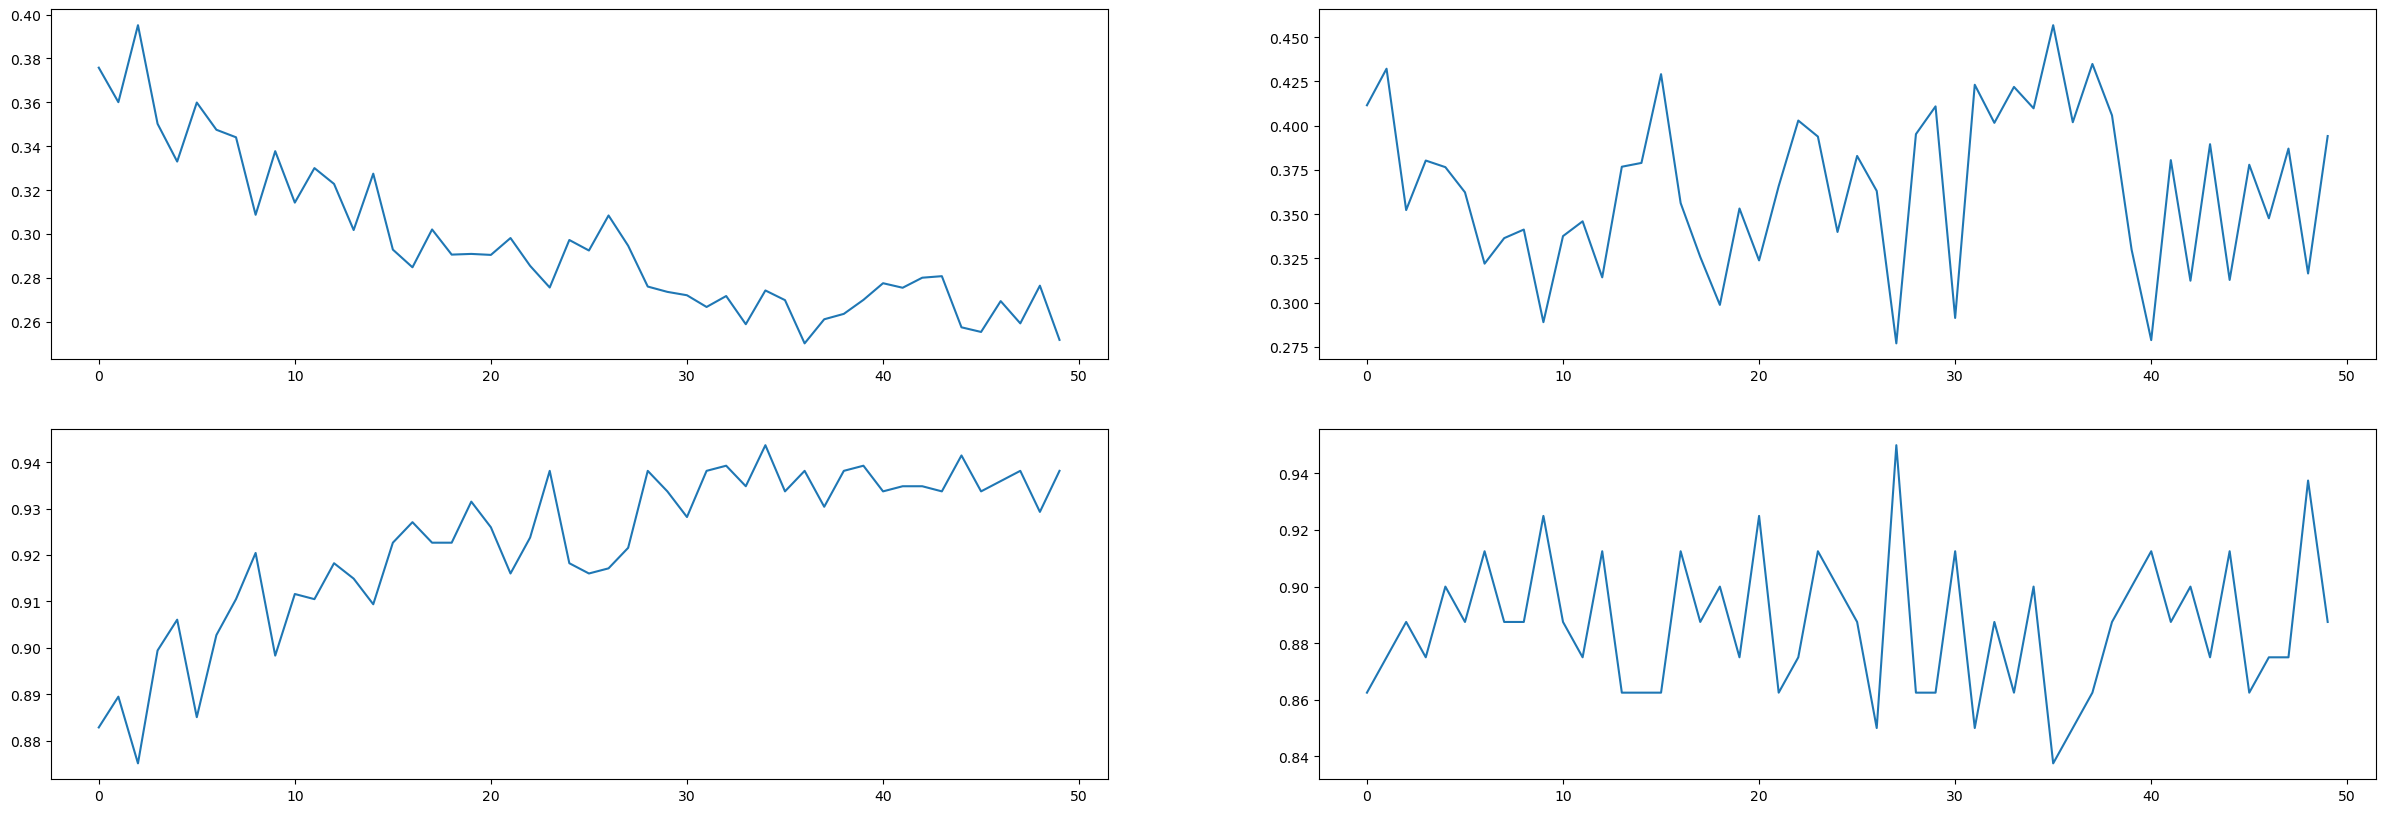

In [ ]:
tf.keras.backend.clear_session()
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = 16,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5308544   
                                                             

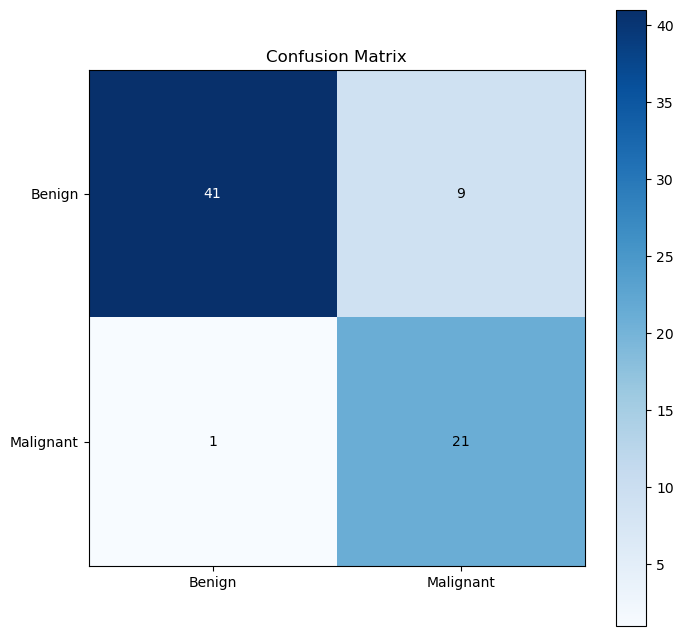

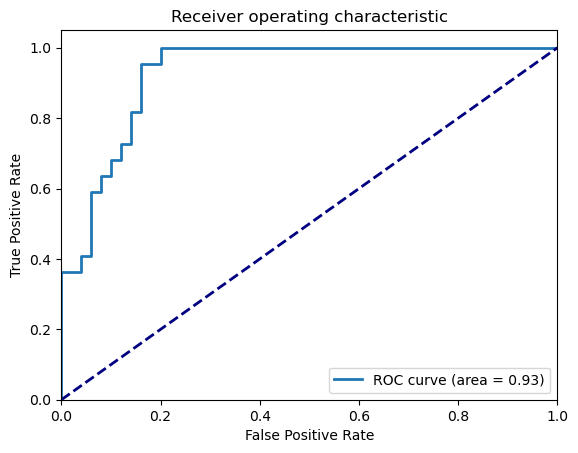

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('vgg16',augmentation=False,flatten='flatten',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,flatten='flatten',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5308544   
                                                             

In [ ]:
# store_misclassified = misclassified_store+'vgg16/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

5/5 [==============================] - 0s 43ms/step


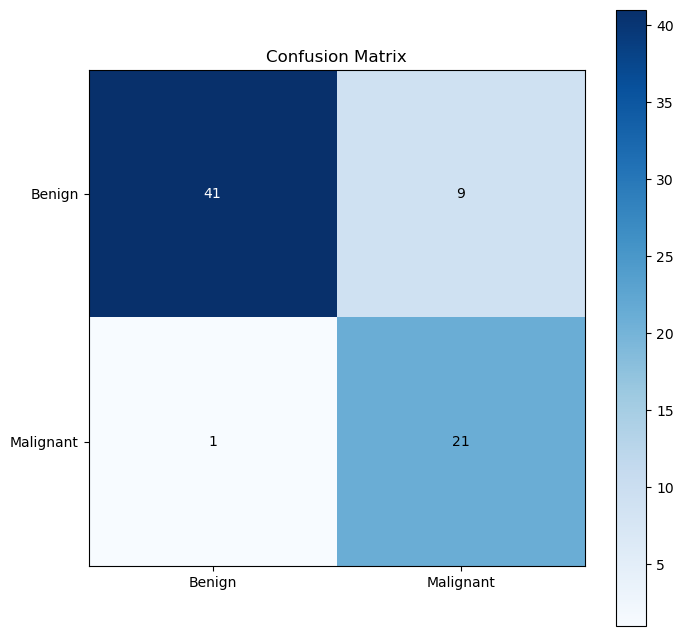

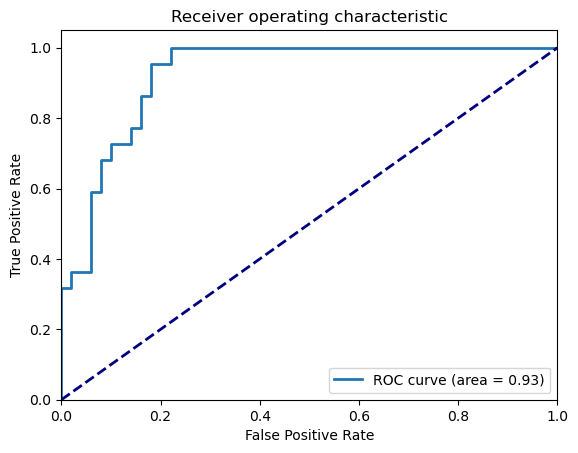

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet

In [ ]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_new_train/'
train_log = '/home/jj/FYP/log/EffcientNetB3_INbreast_new_train/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 128)               19660928  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0     

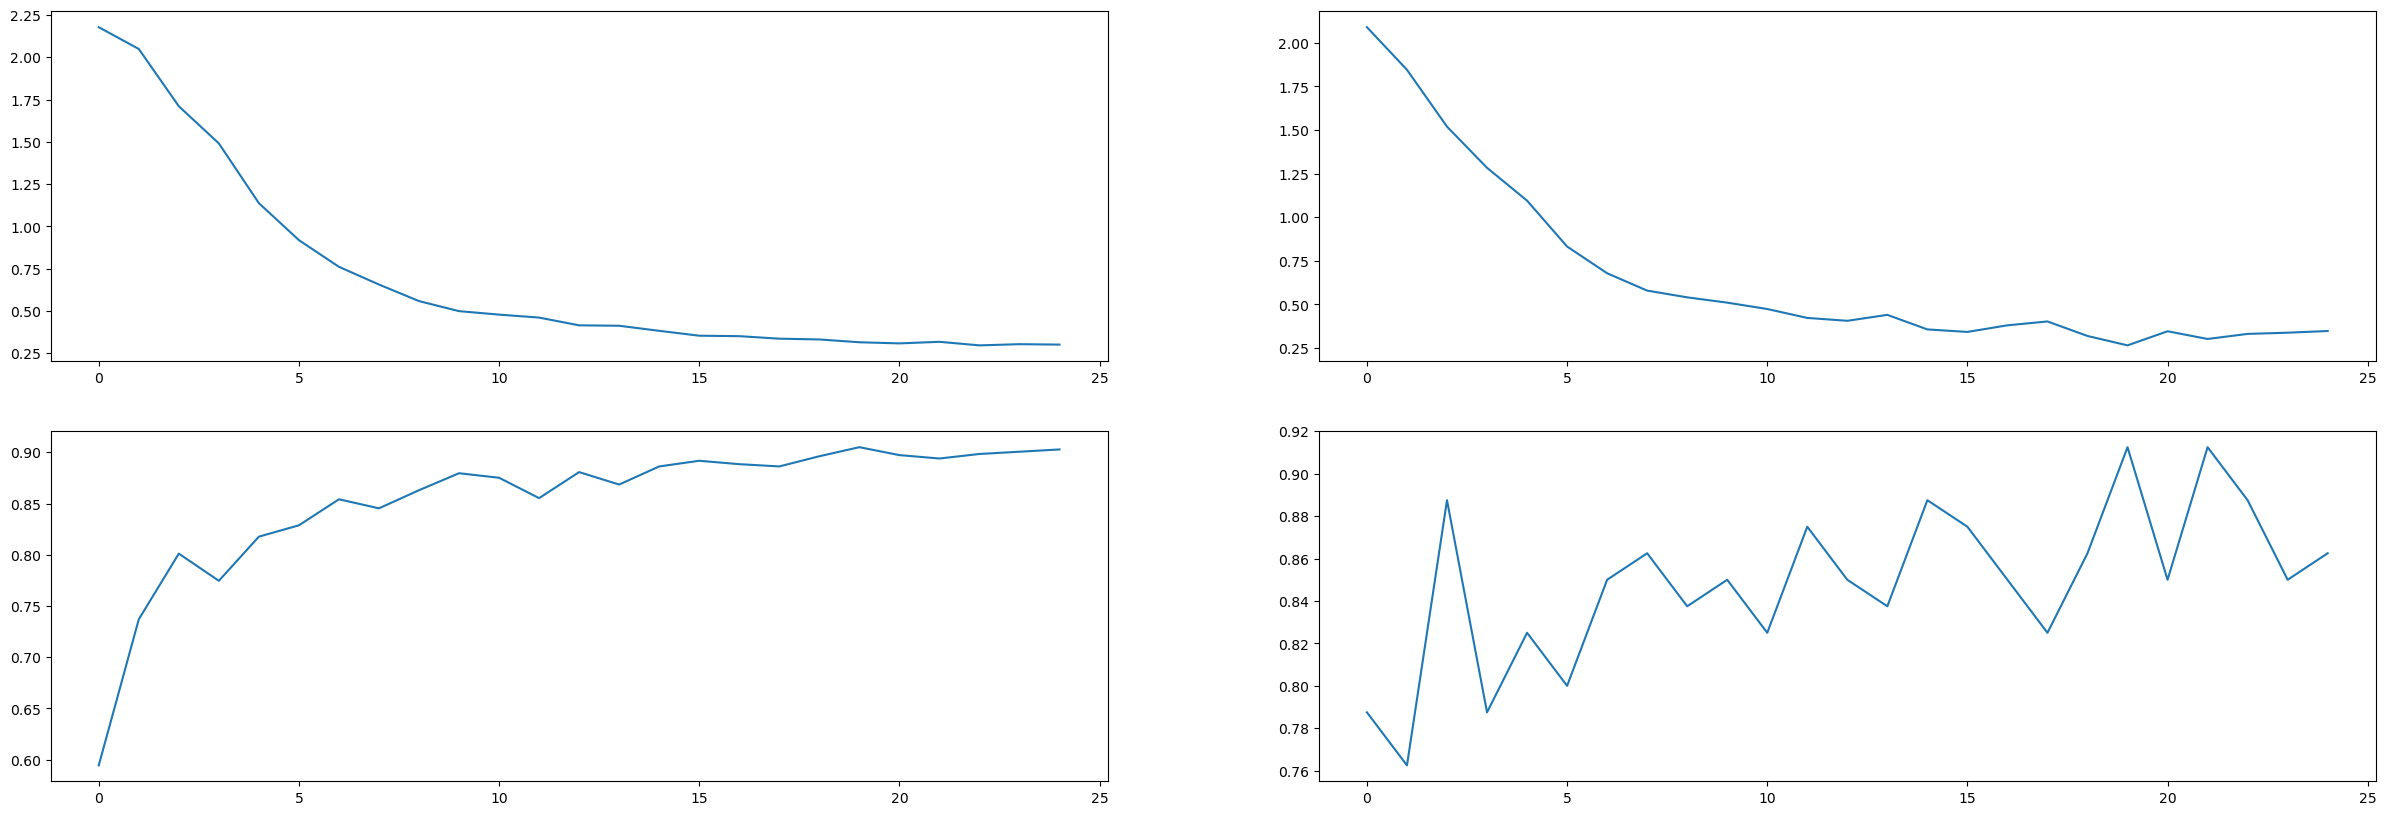

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_new_train/'
train_log = '/home/jj/FYP/log/EffcientNetB3_INbreast_new_train/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = False,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=5,cosine=20,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 128)               19660928  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0     

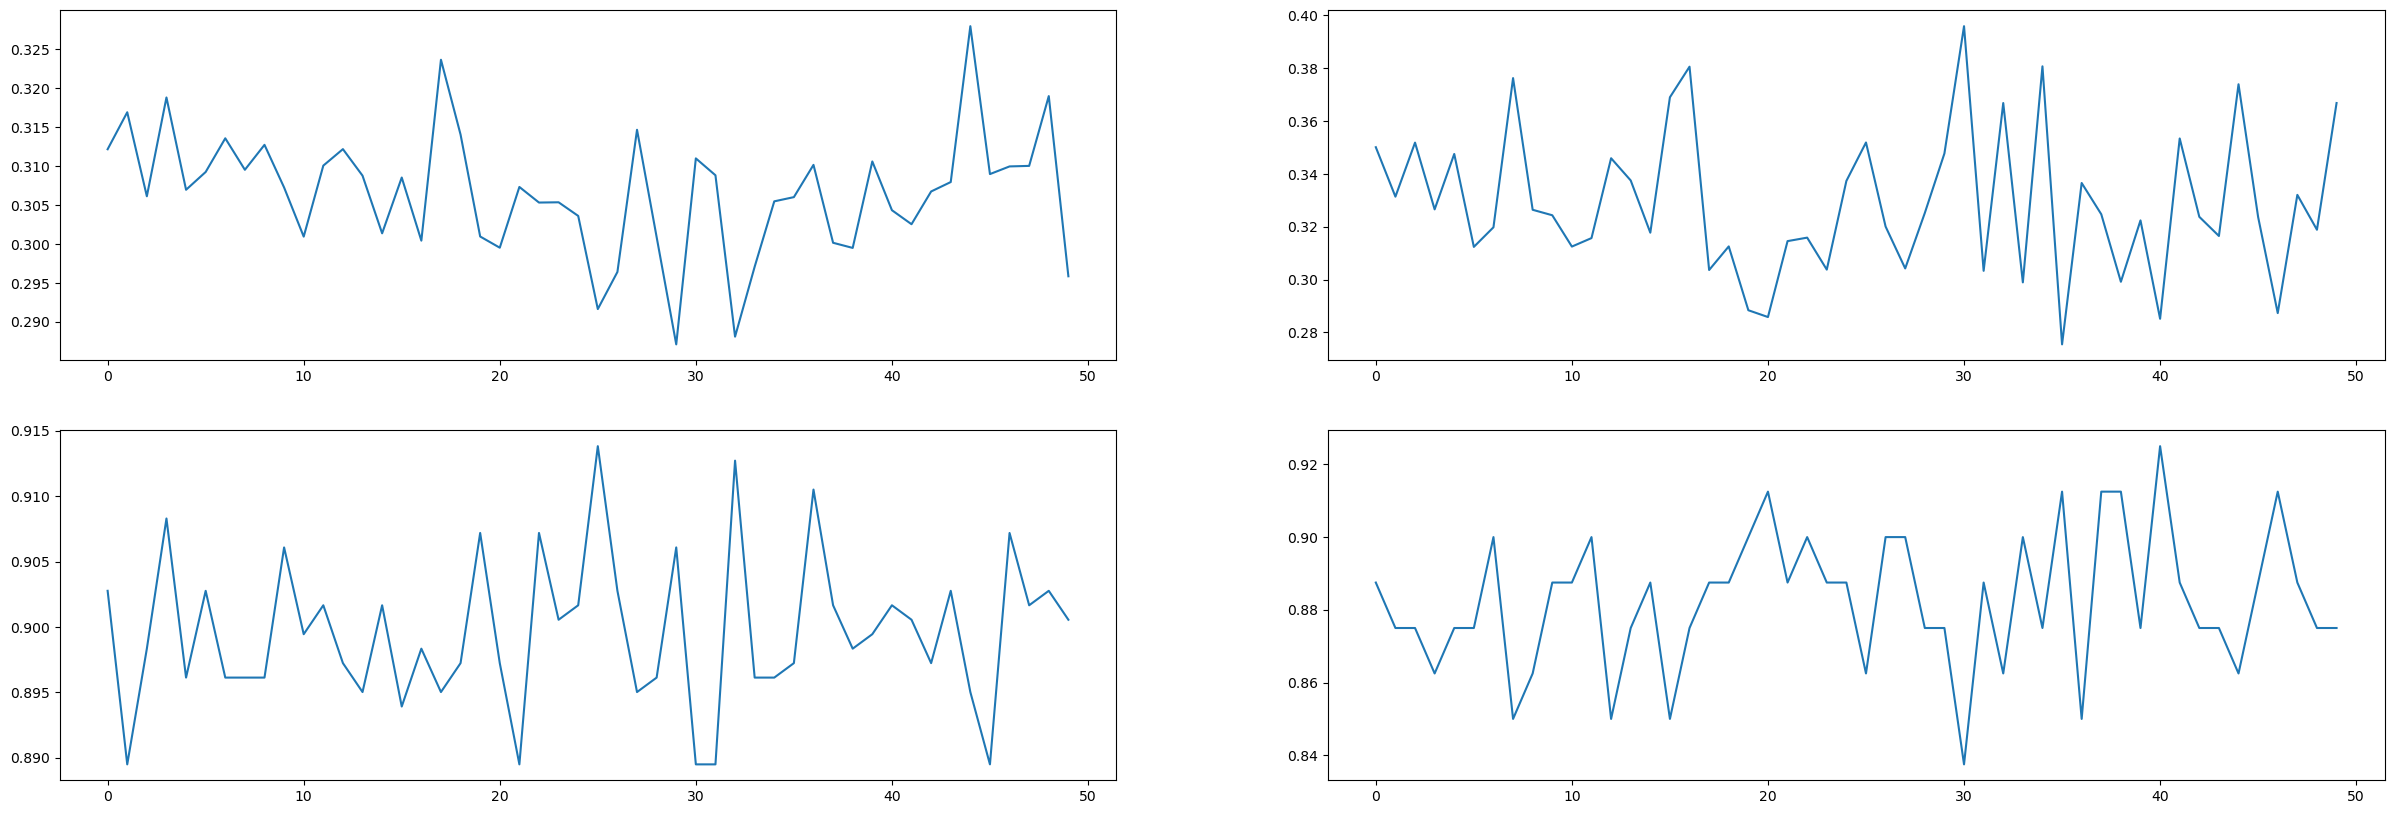

In [ ]:
tf.keras.backend.clear_session()
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = 75,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 128)               19660928  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032  

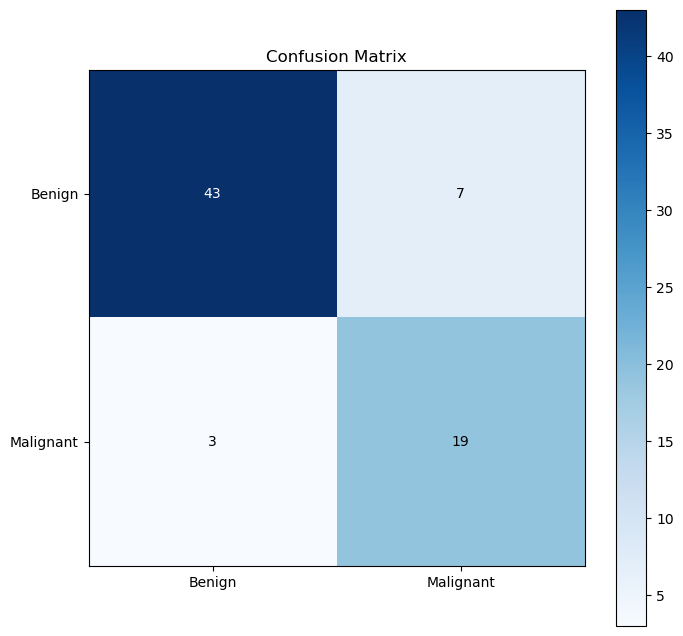

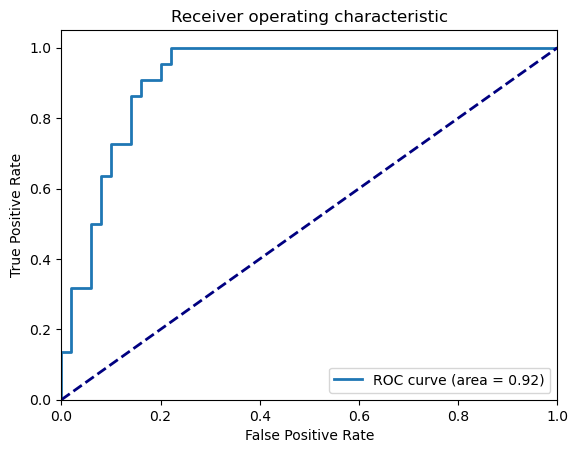

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='flatten',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='flatten',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 128)               19660928  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032  

In [ ]:
# store_misclassified = misclassified_store+'efficientnetb3/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

5/5 [==============================] - 2s 108ms/step


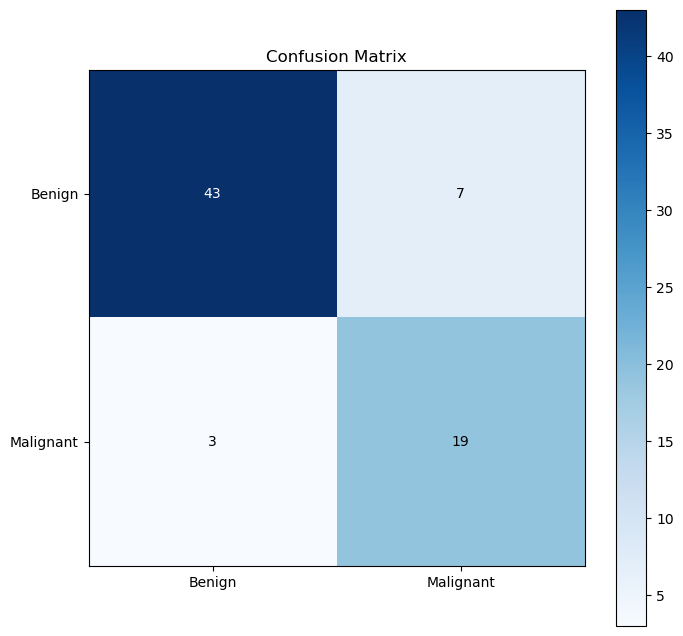

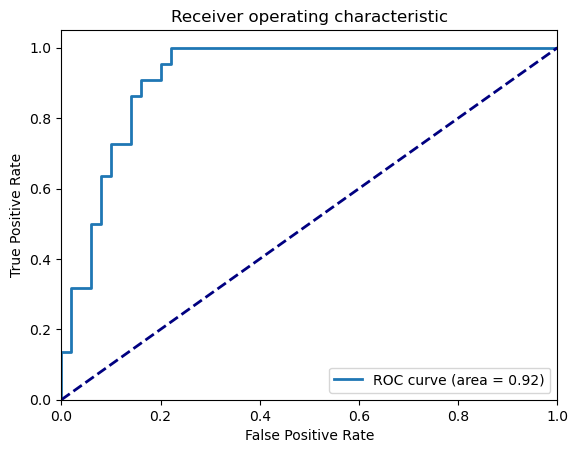

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# ConvNext

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_new_train/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               10616960  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0     

2023-03-15 21:14:46.604137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-15 21:14:48.999365: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f19d4314200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 21:14:48.999417: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-15 21:14:49.567280: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-15 21:14:49.575373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-15 21:14:57.012985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

57/57 [==============================] - 59s 665ms/step - loss: 2.3002 - categorical_accuracy: 0.5547 - precision: 0.5439 - precision_1: 0.5930 - val_loss: 2.1384 - val_categorical_accuracy: 0.5500 - val_precision: 0.5435 - val_precision_1: 0.5588
Epoch 2/2
57/57 [==============================] - 22s 387ms/step - loss: 2.0166 - categorical_accuracy: 0.7459 - precision: 0.7739 - precision_1: 0.7206 - val_loss: 1.6832 - val_categorical_accuracy: 0.8250 - val_precision: 1.0000 - val_precision_1: 0.7407
Epoch 3/3
57/57 [==============================] - 22s 381ms/step - loss: 1.7359 - categorical_accuracy: 0.8000 - precision: 0.8717 - precision_1: 0.7476 - val_loss: 1.5127 - val_categorical_accuracy: 0.8000 - val_precision: 0.9615 - val_precision_1: 0.7222
Epoch 4/4
57/57 [==============================] - 22s 383ms/step - loss: 1.5239 - categorical_accuracy: 0.7768 - precision: 0.8184 - precision_1: 0.7419 - val_loss: 1.2924 - val_categorical_accuracy: 0.8500 - val_precision: 0.8684 - va

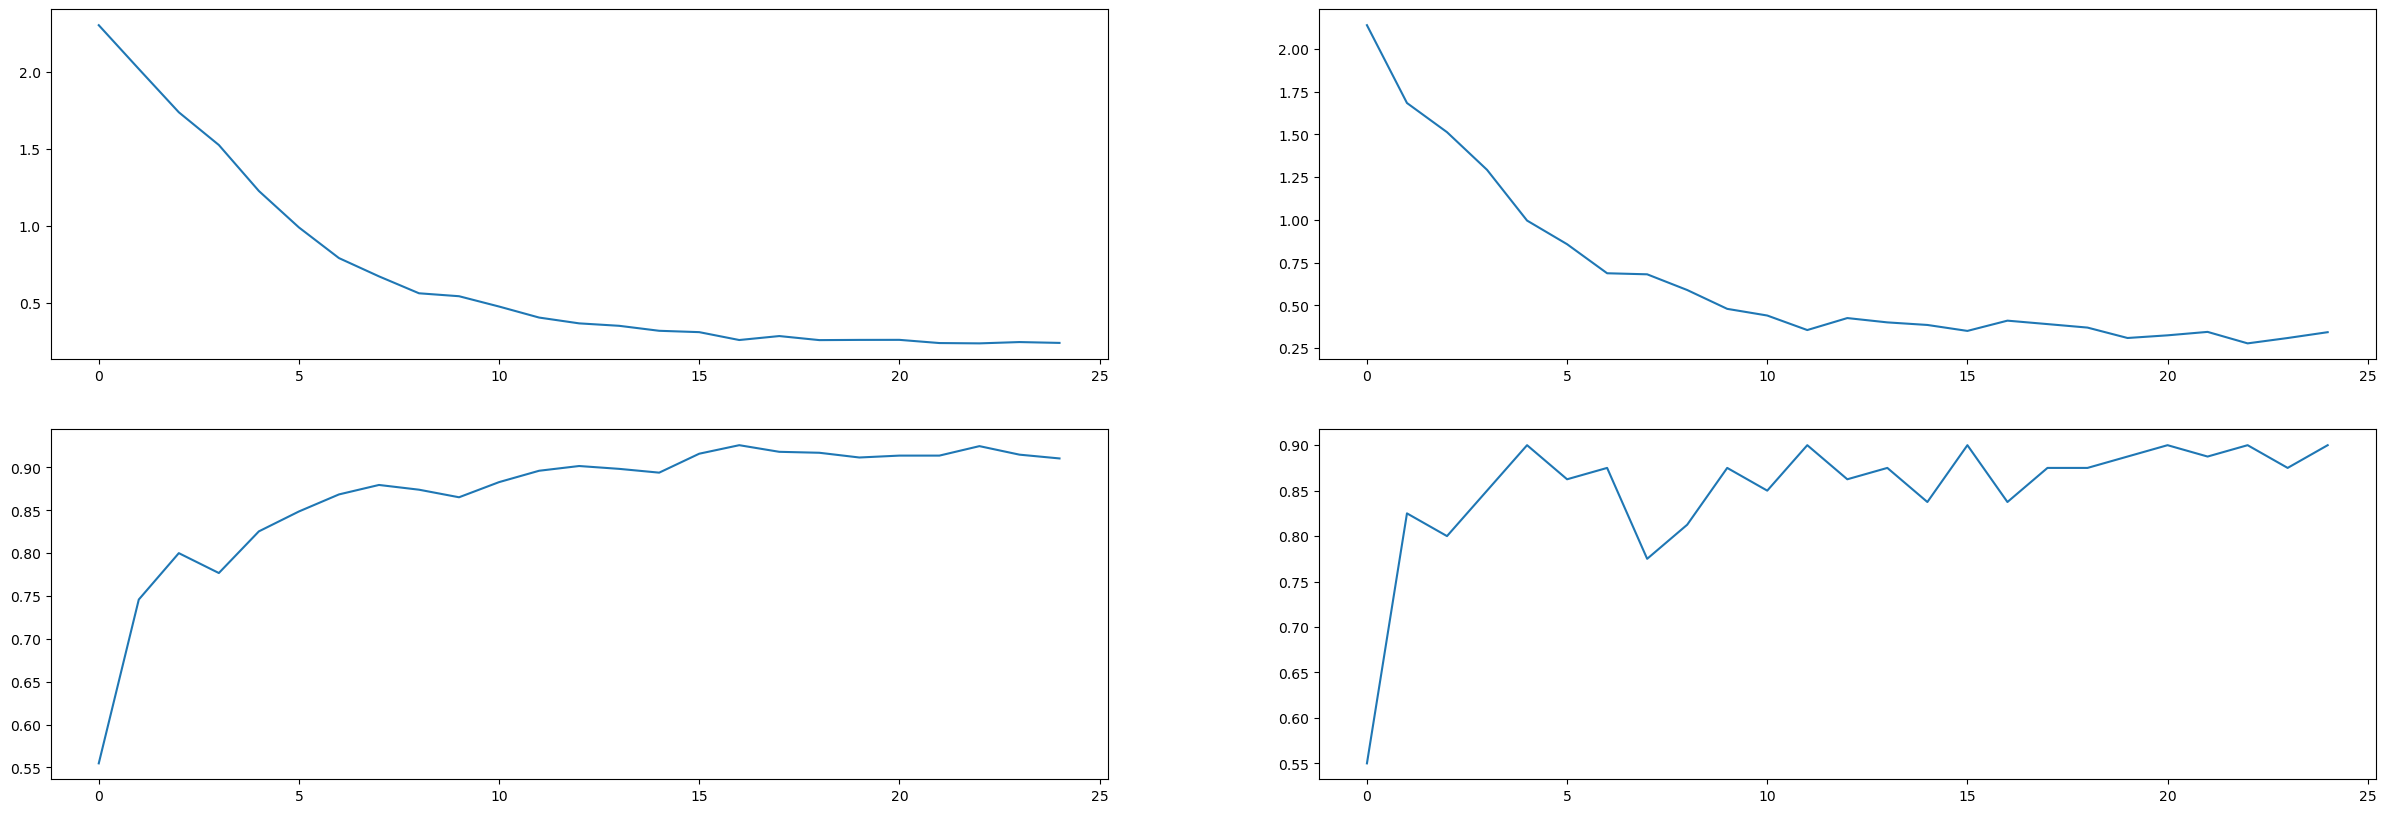

In [ ]:
tf.keras.backend.clear_session()
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = False,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=5,cosine=20,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               10616960  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0     

2023-03-15 21:37:04.710017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-15 21:37:06.883970: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fba23ef85e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 21:37:06.884002: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-15 21:37:07.699597: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-15 21:37:07.707073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


57/57 [==============================] - 48s 537ms/step - loss: 0.2576 - categorical_accuracy: 0.9227 - precision: 0.9438 - precision_1: 0.9022 - val_loss: 0.3634 - val_categorical_accuracy: 0.8750 - val_precision: 0.9167 - val_precision_1: 0.8409
Epoch 2/2
57/57 [==============================] - 23s 401ms/step - loss: 0.2509 - categorical_accuracy: 0.9094 - precision: 0.9209 - precision_1: 0.8978 - val_loss: 0.3134 - val_categorical_accuracy: 0.8875 - val_precision: 0.9429 - val_precision_1: 0.8444
Epoch 3/3
57/57 [==============================] - 23s 402ms/step - loss: 0.2569 - categorical_accuracy: 0.9127 - precision: 0.9367 - precision_1: 0.8898 - val_loss: 0.3347 - val_categorical_accuracy: 0.9000 - val_precision: 0.9211 - val_precision_1: 0.8810
Epoch 4/4
57/57 [==============================] - 23s 400ms/step - loss: 0.2621 - categorical_accuracy: 0.9149 - precision: 0.9330 - precision_1: 0.8972 - val_loss: 0.3136 - val_categorical_accuracy: 0.9000 - val_precision: 0.9706 - va

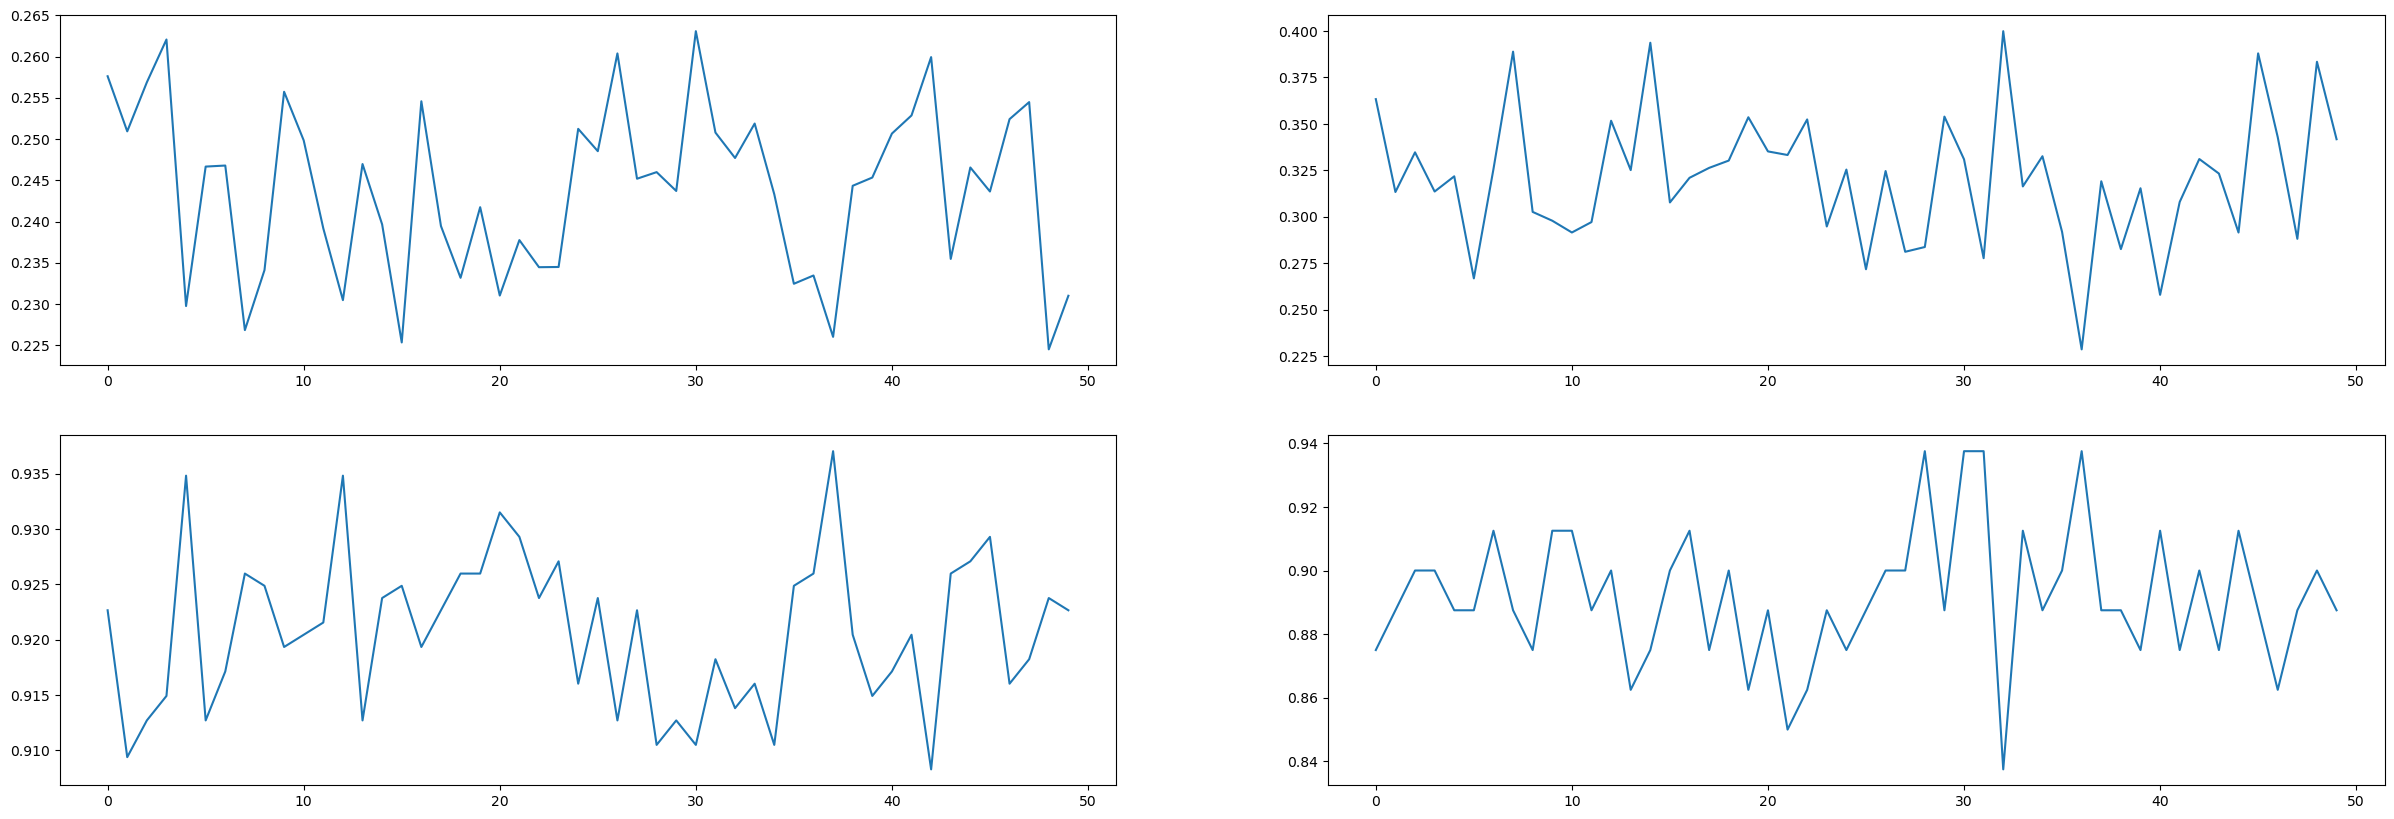

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_new_train/'
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               10616960  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032  

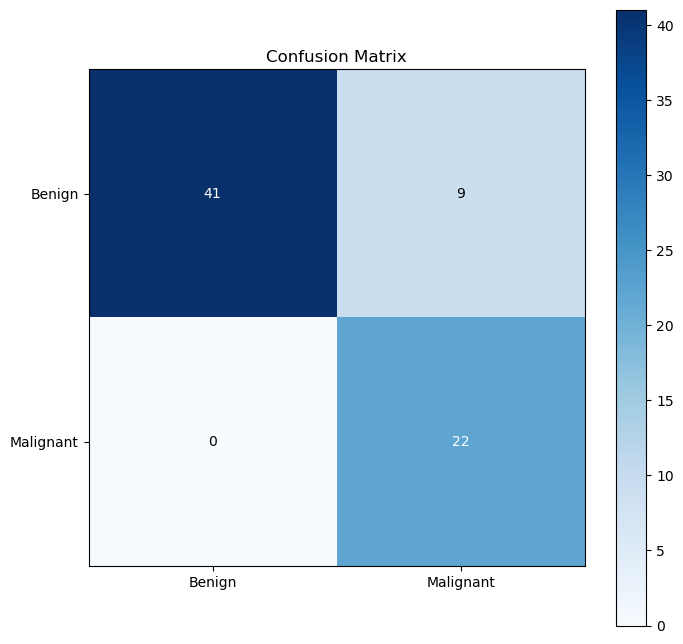

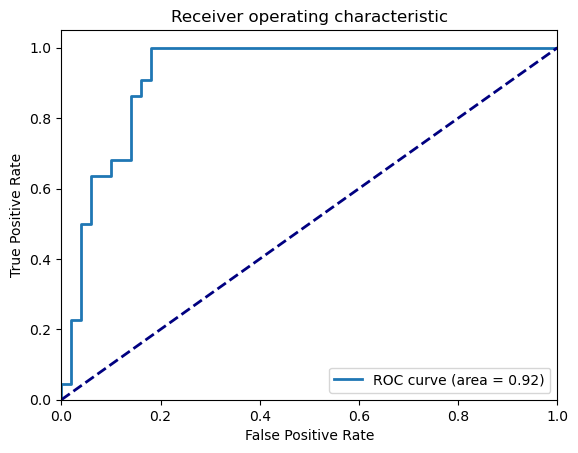

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='flatten',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='flatten',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               10616960  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032  

In [ ]:
# store_misclassified = misclassified_store+'convnext/'
# model.evaluate(test)
# misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
# misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
# misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

5/5 [==============================] - 3s 204ms/step


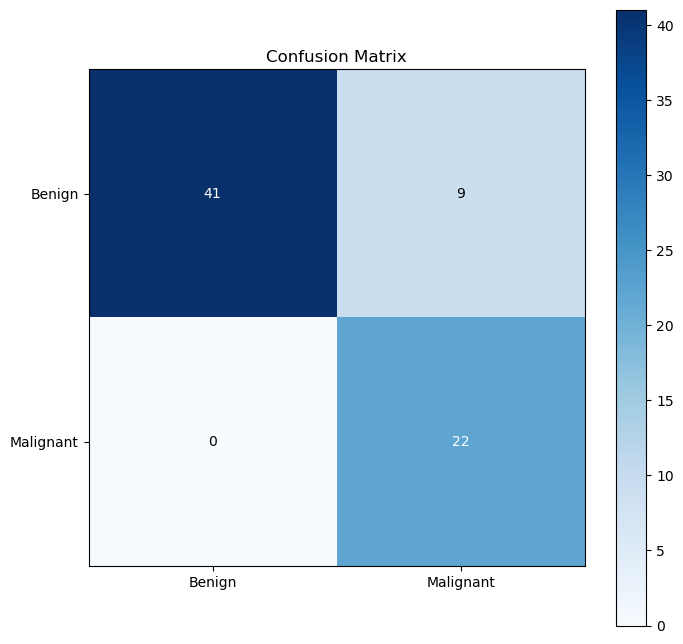

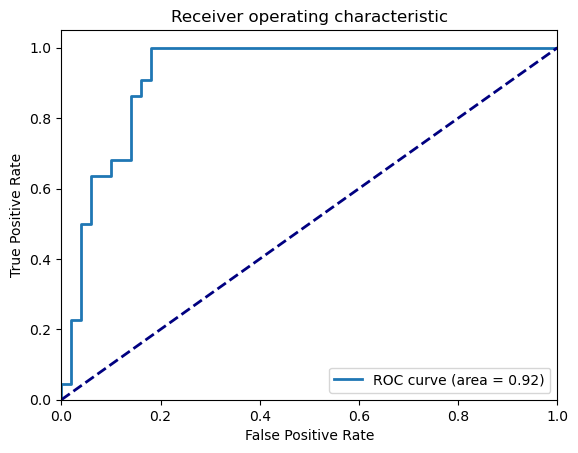

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet V2M

## Initialising

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_INbreast_new_train/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_INbreast_new_train/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = False,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-3,init_lr=1e-6,warmup=5,cosine=20,min_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 128)               16384128  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                             

2023-03-15 21:57:26.214968: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-15 21:57:26.688940: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


57/57 [==============================] - 31s 329ms/step - loss: 2.2607 - categorical_accuracy: 0.5204 - precision: 0.5486 - precision_1: 0.5051 - val_loss: 2.1445 - val_categorical_accuracy: 0.6125 - val_precision: 0.5882 - val_precision_1: 0.6552
Epoch 2/2
57/57 [==============================] - 15s 251ms/step - loss: 2.1014 - categorical_accuracy: 0.6796 - precision: 0.6797 - precision_1: 0.6794 - val_loss: 1.7961 - val_categorical_accuracy: 0.7875 - val_precision: 0.7674 - val_precision_1: 0.8108
Epoch 3/3
57/57 [==============================] - 14s 248ms/step - loss: 1.9125 - categorical_accuracy: 0.7006 - precision: 0.7787 - precision_1: 0.6517 - val_loss: 1.6155 - val_categorical_accuracy: 0.8000 - val_precision: 0.9615 - val_precision_1: 0.7222
Epoch 4/4
57/57 [==============================] - 15s 252ms/step - loss: 1.6178 - categorical_accuracy: 0.7260 - precision: 0.8678 - precision_1: 0.6574 - val_loss: 1.4074 - val_categorical_accuracy: 0.7625 - val_precision: 1.0000 - va

: 

: 

## Fine Tuning

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 128)               16384128  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                             

2023-03-15 18:25:04.785615: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 18:25:04.786130: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


57/57 [==============================] - 30s 337ms/step - loss: 0.2633 - categorical_accuracy: 0.9061 - precision: 0.9502 - precision_1: 0.8675 - val_loss: 0.2744 - val_categorical_accuracy: 0.9125 - val_precision: 0.9714 - val_precision_1: 0.8667
Epoch 2/2
57/57 [==============================] - 15s 269ms/step - loss: 0.2428 - categorical_accuracy: 0.9227 - precision: 0.9399 - precision_1: 0.9057 - val_loss: 0.3801 - val_categorical_accuracy: 0.8750 - val_precision: 0.9412 - val_precision_1: 0.8261
Epoch 3/3
57/57 [==============================] - 15s 268ms/step - loss: 0.2568 - categorical_accuracy: 0.9227 - precision: 0.9540 - precision_1: 0.8936 - val_loss: 0.2983 - val_categorical_accuracy: 0.9250 - val_precision: 1.0000 - val_precision_1: 0.8696
Epoch 4/4
57/57 [==============================] - 16s 271ms/step - loss: 0.2432 - categorical_accuracy: 0.9182 - precision: 0.9494 - precision_1: 0.8894 - val_loss: 0.3383 - val_categorical_accuracy: 0.8875 - val_precision: 0.9189 - va

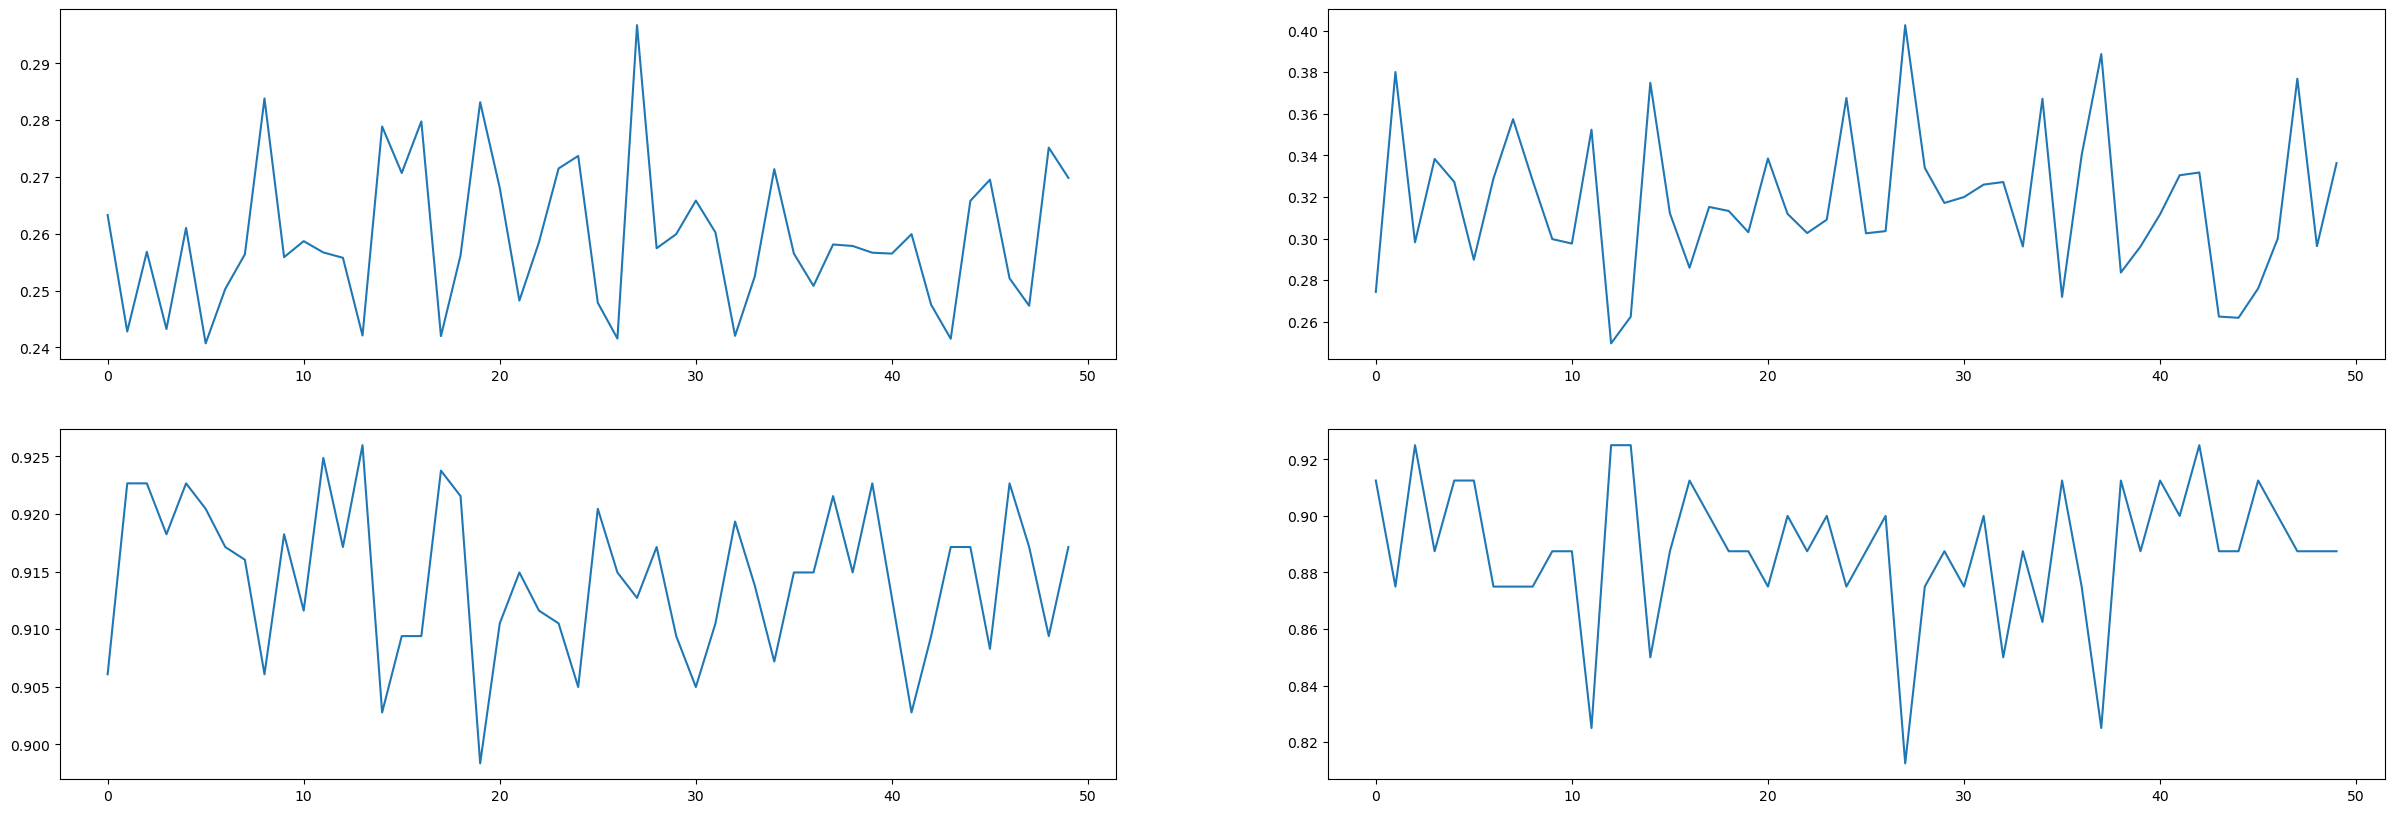

In [ ]:
tf.keras.backend.clear_session()
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = 75,flatten='flatten',
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,warmup=0,cosine=40,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
model.save_weights(weights+'Final/Final')

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 128)               16384128  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

2023-03-15 18:38:25.289471: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


5/5 [==============================] - 3s 149ms/step


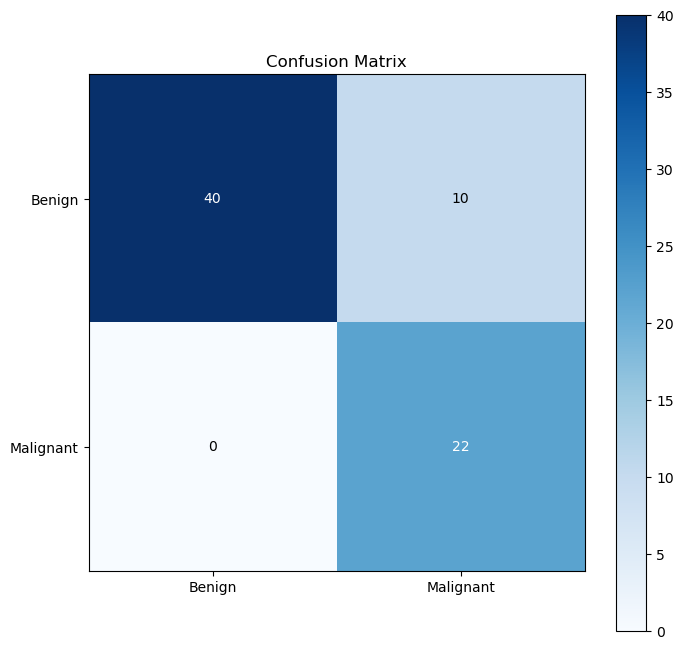

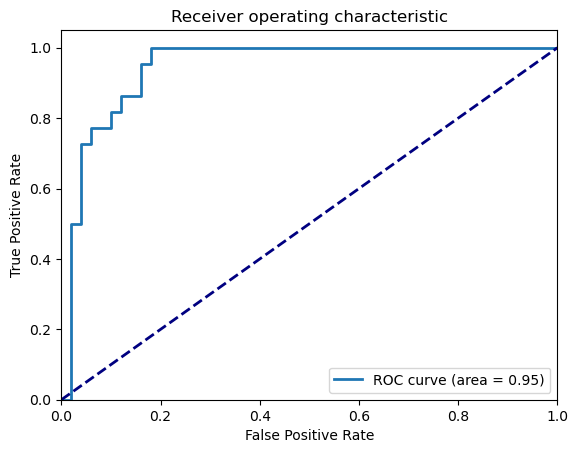

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='flatten',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 128)               16384128  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

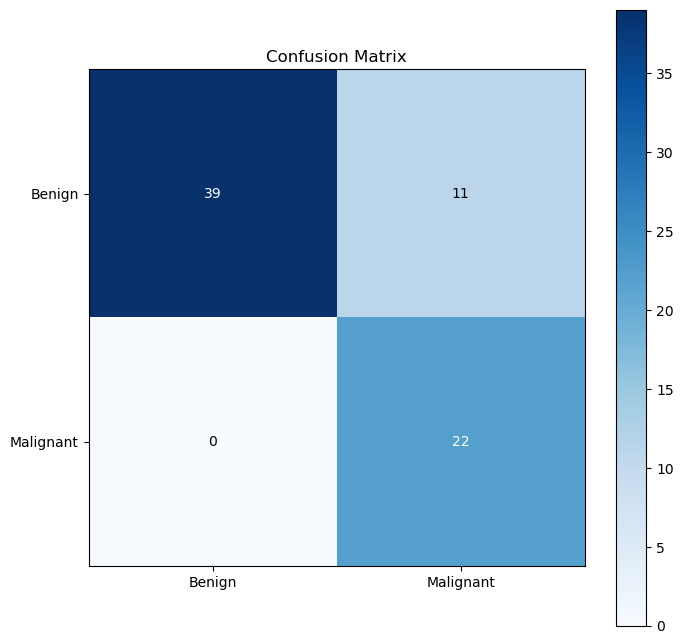

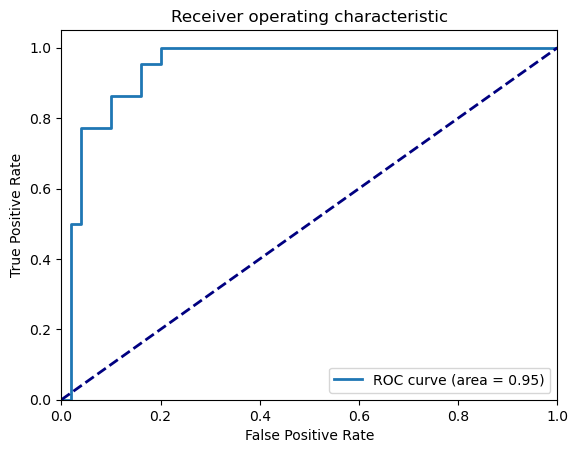

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='flatten',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()